In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random

# =================================================================
# 1단계: 파일 로드 및 기본 전처리
# =================================================================
WINDOW_SIZE = 3
FILE_PATH = '../DB/factory_sample_20pct.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"오류: '{FILE_PATH}' 파일을 찾을 수 없습니다.")
    exit()

df['event_time'] = pd.to_datetime(df['event_time'])

# =================================================================
# 2단계: 단어장 생성
# =================================================================
unique_event_types = df['event_type'].unique().tolist()
event_type_vocab = ['<PAD>', '<UNK>'] + unique_event_types
event_type_to_idx = {etype: i for i, etype in enumerate(event_type_vocab)}
print("--- 생성된 단어장 (사전) ---")
print(f"총 단어 수: {len(event_type_to_idx)}")
# print(event_type_to_idx) # 단어장이 길면 주석 처리
print("-" * 35)

# =================================================================
# 3단계: 텍스트 시퀀스 및 EPC 꼬리표 생성
# =================================================================
sequence_set_text = []
epc_for_each_sequence = []

grouped = df.groupby('epc_code')
for epc, group_df in grouped:
    sorted_group = group_df.sort_values(by='event_time').reset_index(drop=True)
    processed_group = sorted_group[['location_id', 'event_type', 'event_time']]
    if len(processed_group) < WINDOW_SIZE:
        pad_len = WINDOW_SIZE - len(processed_group)
        padding_df = pd.DataFrame({'location_id': [0] * pad_len, 'event_type': ['<PAD>'] * pad_len, 'event_time': pd.to_datetime([pd.NaT] * pad_len)})
        padded_sequence = pd.concat([padding_df, processed_group], ignore_index=True)
        sequence_set_text.append(padded_sequence)
        epc_for_each_sequence.append(epc)
    else:
        num_windows = len(processed_group) - WINDOW_SIZE + 1
        for i in range(num_windows):
            window = processed_group.iloc[i : i + WINDOW_SIZE].reset_index(drop=True)
            sequence_set_text.append(window)
            epc_for_each_sequence.append(epc)

print(f"✅ 3단계: 텍스트 시퀀스 생성 완료. 총 {len(sequence_set_text)}개")

# =================================================================
# 4단계: 텍스트 시퀀스를 숫자 시퀀스로 변환 (모델 입력용)
# =================================================================
sequence_set_processed = []
unk_idx = event_type_to_idx['<UNK>']

for seq_df in sequence_set_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    sequence_set_processed.append(final_df)
    
print(f"✅ 4단계: 숫자 시퀀스 변환 완료. 총 {len(sequence_set_processed)}개")

# =================================================================
# 5단계: 데이터 분리 (Train / Test Split)
# =================================================================
indices = np.arange(len(sequence_set_processed))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sequences_processed = [sequence_set_processed[i] for i in train_indices]
test_sequences_text = [sequence_set_text[i] for i in test_indices]
test_epcs = [epc_for_each_sequence[i] for i in test_indices]

print(f"\n✅ 5단계: 데이터 분리 완료")
print(f"훈련 데이터 수: {len(train_sequences_processed)}")
print(f"테스트 데이터 수: {len(test_sequences_text)}")

# =================================================================
# 6단계: 비정상 데이터 생성 (테스트 데이터셋 기반)
# =================================================================
# 테스트 데이터의 절반을 비정상 데이터로 만듭니다.
n_anomalies_to_create = len(test_sequences_text) // 2

generated_anomalies_text = []
all_event_types = [event for event in event_type_to_idx.keys() if event not in ['<PAD>', '<UNK>']]

for i in range(n_anomalies_to_create):
    normal_sequence_df = test_sequences_text[i].copy()
    real_data_mask = normal_sequence_df['event_type'] != '<PAD>'
    real_data_indices = normal_sequence_df[real_data_mask].index
    if len(real_data_indices) < 2: continue

    anomaly_type = random.choice(['shuffle', 'replace', 'time'])
    anomaly_df = normal_sequence_df.copy()

    if anomaly_type == 'shuffle':
        shuffled_events = anomaly_df.loc[real_data_indices, 'event_type'].sample(frac=1).values
        anomaly_df.loc[real_data_indices, 'event_type'] = shuffled_events
    elif anomaly_type == 'replace':
        replace_idx = random.choice(real_data_indices)
        original_event = anomaly_df.loc[replace_idx, 'event_type']
        possible_replacements = [e for e in all_event_types if e != original_event]
        if not possible_replacements: continue
        new_event = random.choice(possible_replacements)
        anomaly_df.loc[replace_idx, 'event_type'] = new_event
    elif anomaly_type == 'time':
        last_event_idx = real_data_indices[-1]
        anomaly_df.loc[last_event_idx, 'event_time'] += pd.to_timedelta('30D')

    generated_anomalies_text.append(anomaly_df)

print(f"\n✅ 6단계: 비정상 데이터 생성 완료")
print(f"총 {len(generated_anomalies_text)}개의 비정상 시퀀스가 생성되었습니다.")

# =================================================================
# 7단계: 최종 학습 데이터셋 구성 (X_train, y_train)
# =================================================================
# "정상 훈련 데이터 (train_sequences_processed)"만 사용하여 NumPy 배열로 변환합니다.
X_location_list = [seq['location_id'].values for seq in train_sequences_processed]
X_event_type_list = [seq['event_type'].values for seq in train_sequences_processed]
X_time_tan_list = [seq['time_tan'].values for seq in train_sequences_processed]

X_location_np = np.array(X_location_list)
X_event_type_np = np.array(X_event_type_list)
X_time_tan_np = np.array(X_time_tan_list)[..., np.newaxis]

X_train = [X_location_np, X_event_type_np, X_time_tan_np]
y_train = [X_location_np, X_event_type_np, X_time_tan_np]

print(f"\n✅ 최종 단계: 학습 데이터셋 구성 완료")
print("이제 모델을 학습시킬 준비가 되었습니다.")
print(f"Location 데이터 형태: {X_location_np.shape}")
print(f"Event Type 데이터 형태: {X_event_type_np.shape}")
print(f"Time Tan 데이터 형태: {X_time_tan_np.shape}")

--- 생성된 단어장 (사전) ---
총 단어 수: 12
-----------------------------------
✅ 3단계: 텍스트 시퀀스 생성 완료. 총 118426개
✅ 4단계: 숫자 시퀀스 변환 완료. 총 118426개

✅ 5단계: 데이터 분리 완료
훈련 데이터 수: 94740
테스트 데이터 수: 23686

✅ 6단계: 비정상 데이터 생성 완료
총 11843개의 비정상 시퀀스가 생성되었습니다.

✅ 최종 단계: 학습 데이터셋 구성 완료
이제 모델을 학습시킬 준비가 되었습니다.
Location 데이터 형태: (94740, 3)
Event Type 데이터 형태: (94740, 3)
Time Tan 데이터 형태: (94740, 3, 1)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, RepeatVector, TimeDistributed

# 모델 하이퍼파라미터
# LOCATION_VOCAB_SIZE = df['location_id'].nunique() + 1
LOCATION_VOCAB_SIZE = df['location_id'].max() + 1
EVENT_TYPE_VOCAB_SIZE = len(event_type_to_idx)
EMBEDDING_DIM = 8
LATENT_DIM = 8

# 1. 입력층
input_location = Input(shape=(WINDOW_SIZE,), name='input_location')
input_event_type = Input(shape=(WINDOW_SIZE,), name='input_event_type')
input_time_tan = Input(shape=(WINDOW_SIZE, 1), name='input_time_tan')

# 2. 임베딩 및 결합
embedding_location = Embedding(input_dim=LOCATION_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_location)
embedding_event_type = Embedding(input_dim=EVENT_TYPE_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_event_type)
concatenated_inputs = Concatenate()([embedding_location, embedding_event_type, input_time_tan])

# 3. 인코더
encoder_lstm = LSTM(LATENT_DIM, activation='relu')(concatenated_inputs)

# 4. 디코더
repeat_vector = RepeatVector(WINDOW_SIZE)(encoder_lstm)
decoder_lstm = LSTM(EMBEDDING_DIM * 2 + 1, activation='relu', return_sequences=True)(repeat_vector)

# 5. 출력층
output_location = TimeDistributed(Dense(LOCATION_VOCAB_SIZE, activation='softmax'), name='output_location')(decoder_lstm)
output_event_type = TimeDistributed(Dense(EVENT_TYPE_VOCAB_SIZE, activation='softmax'), name='output_event_type')(decoder_lstm)
output_time_tan = TimeDistributed(Dense(1), name='output_time_tan')(decoder_lstm)

# 6. 모델 생성
autoencoder = Model(inputs=[input_location, input_event_type, input_time_tan],
                    outputs=[output_location, output_event_type, output_time_tan])

print("\n✅ 3단계: 오토인코더 모델 구축 완료")
autoencoder.summary()


✅ 3단계: 오토인코더 모델 구축 완료


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_location      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_event_type    │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 3, 8)      │      1,272 │ input_location[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 3, 8)      │         96 │ input_event_type… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_time_tan      │ (None, 3, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3, 17)     │          0 │ embedding_6[0][0… │
│ (Concatenate)       │                   │            │ embedding_7[0][0… │
│                     │                   │            │ input_time_tan[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 8)         │        832 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 3, 8)      │          0 │ lstm_6[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 3, 17)     │      1,768 │ repeat_vector_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_location     │ (None, 3, 159)    │      2,862 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_event_type   │ (None, 3, 12)     │        216 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_time_tan     │ (None, 3, 1)      │         18 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,064 (27.59 KB)

 Trainable params: 7,064 (27.59 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 각 출력에 맞는 손실 함수 지정
losses = {
    'output_location': 'sparse_categorical_crossentropy',
    'output_event_type': 'sparse_categorical_crossentropy',
    'output_time_tan': 'mean_squared_error'
}

autoencoder.compile(optimizer='adam', loss=losses)

print("\n✅ 4단계: 모델 학습 시작")
history = autoencoder.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

print("\n🎉 모델 학습 완료!")


✅ 4단계: 모델 학습 시작
Epoch 1/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 129.1034 - output_event_type_loss: 2.1848 - output_location_loss: 3.7531 - output_time_tan_loss: 123.1656 - val_loss: 6.5173 - val_output_event_type_loss: 1.2846 - val_output_location_loss: 2.2533 - val_output_time_tan_loss: 2.9581
Epoch 2/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.3294 - output_event_type_loss: 1.1234 - output_location_loss: 2.0707 - output_time_tan_loss: 3.1353 - val_loss: 2.9981 - val_output_event_type_loss: 0.7476 - val_output_location_loss: 1.5151 - val_output_time_tan_loss: 0.7175
Epoch 3/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.7986 - output_event_type_loss: 0.6993 - output_location_loss: 1.4433 - output_time_tan_loss: 0.6560 - val_loss: 2.6842 - val_output_event_type_loss: 0.5918 - val_output_location_loss: 1.2598 - val_output_time_tan_loss: 0.8163
Epoch 4/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.8283 - output_event_type_loss: 0.5820 - outpu


✅ 8단계: 모델 평가 시작
최종 테스트 데이터 구성 완료. (정상: 11843개, 비정상: 11843개)
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

모델 AUC 점수: 0.7922
최적 임계값: 1.6842


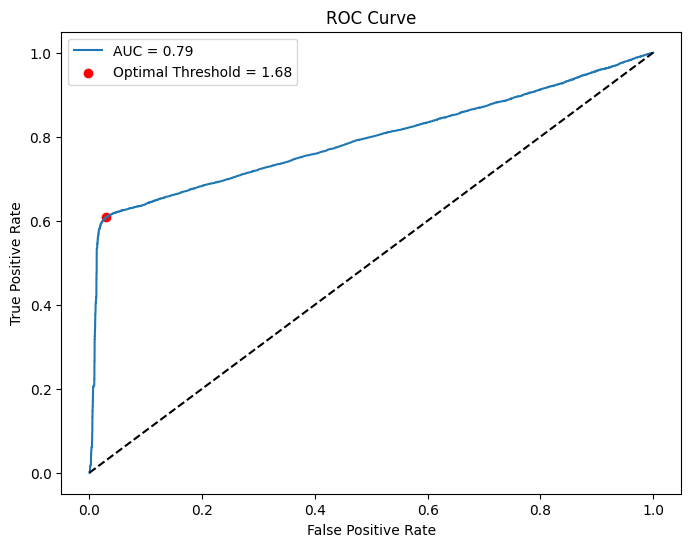


--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.71      0.97      0.82     11843
 Anomaly (1)       0.95      0.61      0.74     11843

    accuracy                           0.79     23686
   macro avg       0.83      0.79      0.78     23686
weighted avg       0.83      0.79      0.78     23686



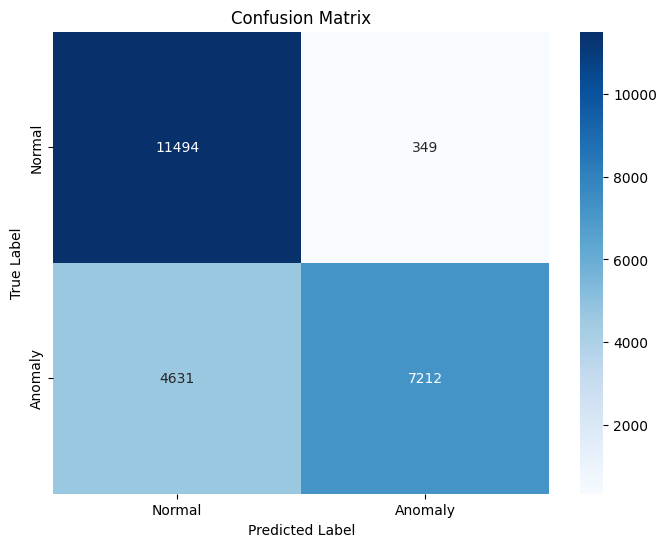


--- 모델이 '비정상'으로 탐지한 이동 목록 (상위 10개) ---
                                           epc_code  from_location  \
6423  001.8804823.1293291.010004.20250701.000004035             59   
285   001.8805843.3812382.010003.20250701.000003523             68   
3623  001.8809437.1203199.100002.20250701.000001916             35   
563   001.8805843.3812382.010003.20250701.000003523             68   
1996  001.8809437.1203199.100002.20250701.000001494             35   
6606  001.8809437.1203199.100002.20250701.000001662             35   
1376  001.8809437.1203199.100002.20250701.000001304             35   
3627  001.8804823.1293291.010004.20250701.000005013             23   
65    001.8805843.3812382.010003.20250701.000003661             59   
3323  001.8804823.1293291.150004.20250701.000004773             41   

      to_location  reconstruction_error      is_correct  
6423           59           1700.349365   True Positive  
285            68           1531.218262  False Positive  
3623           

In [16]:
# =================================================================
# 8단계: 모델 평가 및 이상 탐지 결과 분석
# =================================================================
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

print("\n✅ 8단계: 모델 평가 시작")

# --- 1. 최종 테스트 데이터셋 구성 (정상 + 비정상) ---
# 테스트셋에서 비정상 데이터 생성에 사용되지 않은 나머지 '정상' 데이터
n_anomalies_created = len(generated_anomalies_text)
normal_test_sequences_text = test_sequences_text[n_anomalies_created:]

# 최종 테스트셋 = (정상 테스트 데이터 + 생성된 비정상 데이터)
final_test_sequences_text = normal_test_sequences_text + generated_anomalies_text
# 정답 레이블 생성 (정상: 0, 비정상: 1)
y_test_labels = [0] * len(normal_test_sequences_text) + [1] * len(generated_anomalies_text)

# 테스트 데이터도 모델 입력에 맞게 숫자(processed) 형태로 변환
test_sequences_processed = []
for seq_df in final_test_sequences_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    test_sequences_processed.append(final_df)

# NumPy 배열로 변환
X_test_location = np.array([seq['location_id'].values for seq in test_sequences_processed])
X_test_event_type = np.array([seq['event_type'].values for seq in test_sequences_processed])
X_test_time_tan = np.array([seq['time_tan'].values for seq in test_sequences_processed])[..., np.newaxis]
X_test = [X_test_location, X_test_event_type, X_test_time_tan]

print(f"최종 테스트 데이터 구성 완료. (정상: {y_test_labels.count(0)}개, 비정상: {y_test_labels.count(1)}개)")


# --- 2. 테스트 데이터에 대한 재구성 오류 계산 ---
predicted_test = autoencoder.predict(X_test)
predicted_loc, predicted_event, predicted_time = predicted_test

# Keras 손실 함수를 직접 임포트하여 오류 계산
# from tensorflow.keras.losses import sparse_categorical_crossentropy, mean_squared_error
# loc_errors = np.mean(sparse_categorical_crossentropy(X_test[0], predicted_loc), axis=1)
# event_errors = np.mean(sparse_categorical_crossentropy(X_test[1], predicted_event), axis=1)
# time_errors = np.mean(mean_squared_error(X_test[2], predicted_time), axis=(1, 2))
# total_test_errors = loc_errors + event_errors + time_errors
loc_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[0], predicted_loc), axis=1)
event_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[1], predicted_event), axis=1)
time_errors = np.mean(tf.keras.losses.mse(X_test[2], predicted_time), axis=1)
total_test_errors = loc_errors + event_errors + time_errors


# --- 3. 최적 임계값(Threshold) 찾기 (ROC 커브 활용) ---
fpr, tpr, thresholds = roc_curve(y_test_labels, total_test_errors)
auc_score = roc_auc_score(y_test_labels, total_test_errors)

# 최적 임계값: TPR - FPR이 최대가 되는 지점 (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n모델 AUC 점수: {auc_score:.4f}")
print(f"최적 임계값: {optimal_threshold:.4f}")

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--') # 50% 성능선
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# --- 4. 최종 성능 평가 (Classification Report & Confusion Matrix) ---
final_predictions = (total_test_errors > optimal_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(y_test_labels, final_predictions, target_names=['Normal (0)', 'Anomaly (1)']))

# Confusion Matrix 시각화
cm = confusion_matrix(y_test_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- 5. 모델이 '비정상'으로 판단한 이동 분석 ---
anomaly_indices = np.where(final_predictions == 1)[0]
test_normal_epcs = test_epcs[n_anomalies_created:]
generated_anomaly_epcs = test_epcs[:n_anomalies_created]
final_test_epcs = test_normal_epcs + generated_anomaly_epcs

anomalies_detected = []
for idx in anomaly_indices:
    detected_sequence_df = final_test_sequences_text[idx]
    
    real_data = detected_sequence_df[detected_sequence_df['event_type'] != '<PAD>']
    if len(real_data) < 2: continue

    from_event = real_data.iloc[-2]
    to_event = real_data.iloc[-1]
    
    anomalies_detected.append({
        'epc_code': final_test_epcs[idx],
        'from_location': int(from_event['location_id']),
        'to_location': int(to_event['location_id']),
        'reconstruction_error': total_test_errors[idx],
        'is_correct': 'True Positive' if y_test_labels[idx] == 1 else 'False Positive'
    })

anomaly_df = pd.DataFrame(anomalies_detected).sort_values(by='reconstruction_error', ascending=False)
print("\n--- 모델이 '비정상'으로 탐지한 이동 목록 (상위 10개) ---")
print(anomaly_df.head(10))